# Voter deserts

by Mark Niesse and Nick Thieme.

With gratitude and thanks to Trey Hood, Regina Nuzzo, and Hunter Glanz for methodology suggestions, fact-checking, and help. 

This is the code for the analysis that goes along with the voter deserts story published at: https://www.ajc.com/news/state--regional-govt--politics/precinct-closures-harm-voter-turnout-georgia-ajc-analysis-finds/11sVcLyQCHuQRC8qtZ6lYP/

The code here performs the front-facing analysis given the geocoded data. The statistics and figures in the story are cited and sourced in this notebook. The top line level findings all revolve around the number of voters disenfranchised by their distance to the polls in the 2018 election, and the crucial explosion in the number and percent of voters disenfranchised by distance after the 2012 election, coinciding with the Shelby v Holder decision, in which a 5-4 Republican majority struck down a crucial provision of the Voting Rights Act. 



## Library and data load

In [1]:
########################
#####/_______________/##
####/~Voter Deserts~/###
###/Nick Thieme AJC/####
##/---------------/#####
########################

#############
###Library###
#############

suppressMessages(library(dplyr))
suppressMessages(library(tidyverse))
suppressMessages(library(sf))
suppressMessages(library(tidycensus))
suppressMessages(library(httr))
suppressMessages(library(data.table))
suppressMessages(library(viridis))
suppressMessages(library(lubridate))
suppressMessages(library(gridExtra))
suppressMessages(require(ggplot2))
suppressMessages(library(geosphere))

source("~/Desktop/R_files/functions.R")
setwd("~/Desktop/Datasets/voter_deserts")


###############
###Functions###
###############

###This is the principal function that does the heavy lifting here. It contains the logic that 
###allows one function to handle the analysis for both the absentee and the election day data, and it performs
###That analysis.

run_distance <-function(V, dist_threshold, voted_last_flag=TRUE, inc = FALSE,V_day_of_for_abs=FALSE){
    
    ###This line of code is run regardless of what other conditions are true/untrue, so we run them outside the
    ###logic. There area couple magic numbers here. 1609.34 is the number of meters in a mile (roughly). Since
    ###geosphere gives distances in meters (for obvious reasons), we need to convert back for an American audience.
    ###Income cutoffs are related to the GA income distribution and were varied in a sensitivity analysis.
 
    V_demo<-V[,c("dist_by_area","wealth", "age"):=.(

          dists/(area*1609.34),
          case_when(med_inc>85000~"high_inc", med_inc<35000~"low_inc", (med_inc>=35000)&(med_inc<=85000)~"med_inc"),
           case_when(age>65~"old", age<35~"young", (age<=65)&(age>=35)~"middle")
     
        )
    ]



    d_18<-   V_demo[
            ,distance:=.(case_when(dist_by_area>=dist_threshold~"high_dist", dist_by_area<dist_threshold~"low_dist"))
        ]
    
    if(inc==FALSE){
        if(voted_last_flag == TRUE){ #This call gives us the difference in voting rates, accounting
            ###for various demographic categories, between voters near the polls and voters far from the polls.
            ###It also gives us the number of people from those demographics that are far from the polls.
            ###Importantly, it gives these figures per county. The effect of distance from the polls is certain to 
            ###depend on the county we're talking about, so we condition in that way. 
            ###
            ###The general way our estimate works is that we get the difference in voter turnout due to distance
            ###and multiply the number of people far from the polls by that figure to get the expected number of
            ###people who would have voted if everyone was close.
            
            
            T<-d_18[,.N, by=.(distance, vote_type, voted_last, age,race, county)][
                vote_type%in%c("no_vote","in_person")] %>% spread(vote_type,N) %>% 
            mutate(in_person = ifelse(is.na(in_person), 0, in_person),
                  no_vote = ifelse(is.na(no_vote), 0, no_vote)) %>% 
            mutate(vote_perc = in_person/(no_vote+in_person), N_tot = in_person+no_vote) %>% 
            select(distance, race,county,age, voted_last, vote_perc, N_tot)%>% 
        filter(distance%in%c("high_dist","low_dist")) %>% 
            group_by(race,age,voted_last, county)  %>% mutate(N_in = n())%>% filter(N_in>1)%>% 
            summarise(
                perc_diff=vote_perc[which(distance=="low_dist")]-vote_perc[which(distance=="high_dist")],
                      N_tot =N_tot[which(distance=="high_dist")]
            ) %>% mutate(num_affected = perc_diff*N_tot) %>% group_by(race) %>% 
            summarise(num_affected = sum(num_affected, na.rm = TRUE),
                     N_tot = sum(N_tot, na.rm=TRUE))
        }else{        #this section gets used when we don't have absentee data but also don't have the 
            ###the previous election's voting data.
            T<-d_18[,.N, by=.(distance, vote_type, age,race, county)][
                vote_type%in%c("no_vote","in_person")] %>% spread(vote_type,N) %>% 
            mutate(in_person = ifelse(is.na(in_person), 0, in_person),
                  no_vote = ifelse(is.na(no_vote), 0, no_vote)) %>% 
            mutate(vote_perc = in_person/(no_vote+in_person), N_tot = in_person+no_vote) %>% 
            select(distance, race,county,age, vote_perc, N_tot)%>% 
        filter(distance%in%c("high_dist","low_dist")) %>% 
            group_by(race,age, county)  %>% mutate(N_in = n())%>% filter(N_in>1)%>% 
            summarise(
                perc_diff=vote_perc[which(distance=="low_dist")]-vote_perc[which(distance=="high_dist")],
                      N_tot =N_tot[which(distance=="high_dist")]
            ) %>% mutate(num_affected = perc_diff*N_tot) %>% group_by(race) %>% 
            summarise(num_affected = sum(num_affected, na.rm = TRUE),
                     N_tot = sum(N_tot, na.rm=TRUE))
            }
    }else{#this section gets used when we have absentee data and the previous election's voting data.
        if(voted_last_flag == TRUE){
            T<-d_18[,.N, by=.(distance, vote_type,wealth, voted_last, age,race, county)][
                vote_type%in%c("no_vote","in_person")] %>% spread(vote_type,N) %>% 
            mutate(in_person = ifelse(is.na(in_person), 0, in_person),
                  no_vote = ifelse(is.na(no_vote), 0, no_vote)) %>% 
            mutate(vote_perc = in_person/(no_vote+in_person), N_tot = in_person+no_vote) %>% 
            select(distance, race,county,age,wealth, voted_last, vote_perc, N_tot)%>% 
        filter(distance%in%c("high_dist","low_dist")) %>% 
            group_by(race,age,voted_last, wealth,county)  %>% mutate(N_in = n())%>% filter(N_in>1)%>% 
            summarise(
                perc_diff=vote_perc[which(distance=="low_dist")]-vote_perc[which(distance=="high_dist")],
                      N_tot =N_tot[which(distance=="high_dist")]
            ) %>% mutate(num_affected = perc_diff*N_tot) %>% group_by(race) %>% 
            summarise(num_affected = sum(num_affected, na.rm = TRUE),
                     N_tot = sum(N_tot, na.rm=TRUE))
        }else{        #this section gets used when we don't have absentee data but also don't have the 
            ###the previous election's voting data.
            T<-d_18[,.N, by=.(distance, vote_type, age,race,wealth, county)][
                vote_type%in%c("no_vote","in_person")] %>% spread(vote_type,N) %>% 
            mutate(in_person = ifelse(is.na(in_person), 0, in_person),
                  no_vote = ifelse(is.na(no_vote), 0, no_vote)) %>% 
            mutate(vote_perc = in_person/(no_vote+in_person), N_tot = in_person+no_vote) %>% 
            select(distance, race,county,age,wealth, vote_perc, N_tot)%>% 
        filter(distance%in%c("high_dist","low_dist")) %>% 
            group_by(race,age,wealth, county)  %>% mutate(N_in = n())%>% filter(N_in>1)%>% 
            summarise(
                perc_diff=vote_perc[which(distance=="low_dist")]-vote_perc[which(distance=="high_dist")],
                      N_tot =N_tot[which(distance=="high_dist")]
            ) %>% mutate(num_affected = perc_diff*N_tot) %>% group_by(race) %>% 
            summarise(num_affected = sum(num_affected, na.rm = TRUE),
                     N_tot = sum(N_tot, na.rm=TRUE))
            }
    }
        return(list(
            "white_num"=T %>% filter(race=="WH") %>% pull(num_affected),
            "black_num"=T %>% filter(race=="BH") %>% pull(num_affected),
            "white_tot"=T %>% filter(race=="WH") %>% pull(N_tot),
            "black_tot"=T %>% filter(race=="BH") %>% pull(N_tot),
            "tot_num" = T %>% pull(num_affected) %>% sum
        )
    )

}

In [2]:
options(warn=-1)
source("~/Desktop/R_files/functions.R")
setwd("~/Desktop/Datasets/voter_deserts")

V_roll_hist_census_18_prev<-fread("final_data_18.csv")
V_roll_hist_census_12<-fread("final_data_12.csv")
polls_locs_18<-read_csv("polling_geo_locs.csv") #2018 poll data
polls_locs_12<-read_csv("polls_12_geolocated.csv")

Read 6768686 rows and 28 (of 28) columns from 1.899 GB file in 00:00:30
Read 3784787 rows and 16 (of 16) columns from 0.547 GB file in 00:00:05


Parsed with column specification:
cols(
  address = col_character(),
  lat = col_double(),
  long = col_double(),
  county = col_character()
)
Parsed with column specification:
cols(
  VANPrecinctID = col_integer(),
  NationalPrecinctCode = col_character(),
  PrecinctID = col_integer(),
  locality_type = col_character(),
  locality_name = col_character(),
  PrecinctName = col_character(),
  PollingLocationName = col_character(),
  PollingLocationAddress = col_character(),
  PollingLocationCity = col_character(),
  PollingLocationState = col_character(),
  PollingLocationZip = col_integer(),
  addr = col_character(),
  lat = col_double(),
  long = col_double(),
  county = col_character()
)


## Modeling overview

### Intro

This section presents one of the primary results: that distance has a significant effect on voter behavior and that the effect is mediated by race. The other large result, that there has been a significant change, both qualitatively and quantitatively between 2012 and 2018, is presented in a later section. 

The methodology, which is as simple as possible, creates contingency tables over variables related to voter turnout and then calculates marginal sums from those tables. 

The code used to calculate those tables is contained in the library function "run_distance."

The variables in the table are: race (a dichotomous variable that is either Black, "BH", or White, "WH"), wealth (a value we bucket into three categories: low, medium, and high, in accordance with BLS values), distance
(which is measured in percent of precinct traveled to the polls, and then dichotimized into near or far), age (trichotimized into young, medium, old by the usual values <35, 35-65, >65), and prior voting (whether or not a voter voted in the prior election), and county.

After bucketing voters by those categories, we then calculate vote_prec (the percentage of voters in a given demographic that voted), num_voted (the number of voters in a given demographic that voted), N_tot (the number of voters in a given demographic), and perc_in_dist (the percentage of a demographic bucket that falls into a particular distance category. 

With the exception of education (which is well predicted by the above variables), those categories are broadly understood to make up the majority of consistently predictable voter behavior, and were decided upon after reviews of the literature and conversations with political scientists. There are many sources for this information, but an older high-level overview of the demographics of voters is contained in Who Votes? (Wolfinger and Rosenstone). More recent examples include: https://www.census.gov/newsroom/blogs/random-samplings/2017/05/voting_in_america.html and https://www.demos.org/research/why-voting-gap-matters.

We vary the cutoff values for income, and whether to include prior voter behavior in the analysis in order to obtain a range of estimates. Likewise, we vary the distance threshold as a form of sensitivity analysis and for policy reasons. 

### Causal graphs

One of the major modeling choice to make at this point is which variables to include to properly estimate the causal effect of distance on voter behavior. The statistical theory on this question is both rich and interesting. We use the work done in Perkovic (2015) to determine the canonical set of adjustment variables needed to properly estimate causal effects. 

However, for many reasonable specifications of the causal graph, that set of variables differs from the set recommended by political scientists consulted in refining the methodology. Rather that discarding either the theory or the domain knowledge, we use both sets and present ranges of estimates.

The code in the cell immediately following this one specifies the graph and plots it. Unfortunatey, installing ggdag's dependencies on my Jupyter Notebook's R kernel was not a good use of time, so I ran the code locally, and exported images. Fair warning to anyone who's interested in reusing this code.

In [ ]:
smoking_ca_dag <- dagify(
                         income ~ county,
                         distance ~ county,
                         income ~ age,
                         distance ~ age,
                         income ~ race,
                         distance ~ race,
                         prior_voting ~ distance + income,
                         voting ~ prior_voting, 
                         exposure = "distance",
                         outcome = "voting",
                         labels = c("income" = "Income", 
                                    "distance" = "Distance",
                                    "age" = "Age",
                                    "race"="Race",
                                    "county" = "County",
                                    "prior_voting"="Voted in last election",
                                    "voting"= "Voted in current election")
                         ) %>% tidy_dagitty()

ggdag(smoking_ca_dag, use_labels = "label", text = FALSE, stylized = TRUE, force=20)+theme_dag()
ggdag_adjustment_set(smoking_ca_dag, type = "canonical")+theme_dag()


This is one of many representative graphs that specify the causal structure of our problem. Age, race, and county function as roots for the DAG. They have no causal parents. One possible change is to give county causal parents. This change doesn't affect the canonical adjustment set in any important ways. Income and distance are children of age, race, and county. Each of these in turn affect whether someone voted in the last election, which itself is causally prior to voting in this election. Direct causal links between the roots and leaf (voted in current), and between the roots and voting in last election are almost certainly included in the true graph structure, but because they don't affect the adjustment set but do clutter the graph, we exlude them here.

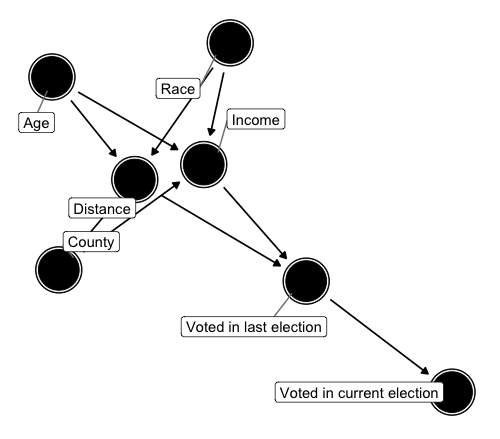

In [25]:
display_png(file="dag_voting.png")

R's ggdag package allows for calculation of the canonical adjustment set. Variables in red are those that need to be adjusted for to estimate the causal effect of distance on current voting. The theory tells us that adjusting for other variables will bias the results. However, when working with causal graphs, a combination of theory and expert knowledge is important, so we include estimates both with and without prior voting.

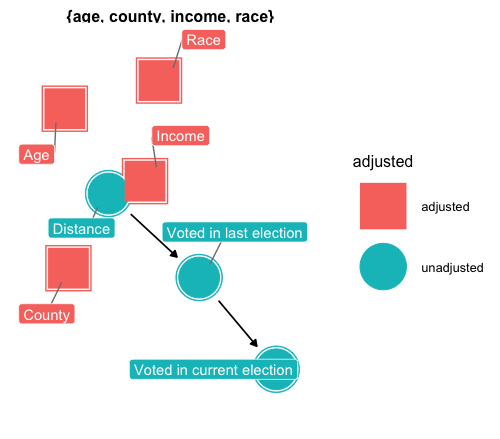

In [23]:
display_png(file="adj_set.png")  

### Theoretical explanation of the estimate

Let X be the number of people from a fixed demographic whose distance to their 2018 polling place was above a fixed threshold and who also voted in the 2018 election. 

Let Y be the number of people from that same demographic who would have voted in the 2018 election if they had been below the fixed threshold instead of above it. 

X can be modeled as a binomial random variable with N equal to the number of people whose distance to their 2018 polling place was above a fixed threshold, our best estimate of its probability parameter p<sub>x</sub> being the actual proportion of those people who did vote, and one of those N people voting being considered a success.

Y is a little tricker, but if we assume that the only difference between the population of X and the population of Y is their distance to the polls, then we can also model Y as a binomial random variable identical to X with the exception of its probabiliy of success, p<sub>y</sub>. p<sub>y</sub> is instead taken as the proportion of registered voters who voted, fell into the same demographic bucket as those considered in X, but were below the distance threshold.

So: $$X \texttt{~} Bin(N_{demo}, p_{x, demo})$$ and: $$Y \texttt{~} Bin(N_{demo}, p_{y, demo})$$

That makes: $$Z=Y-X$$ a random variable that gives the difference between the number of people from a fixed demographic who would have voted in 2018 if they were "sufficiently" close to their polling place and the number of people from that demographic who did vote despite being further away from their polling place. 

If we assume the difference in voter turnout between these groups is caused by their distance from the polls, then this random variable models the number of people who didn't vote because of their distance from the polls. 

The expected value of this random variable is:

$$E[Y-X]=E[Y]-E[X]= N_{demo}p_{y, demo}-N_{demo} p_{x, demo}=N_{demo}(p_{y, demo}-p_{x, demo})$$

The estimate above is then: $$\sum_{demo}N_{demo}(p_{y, demo}-p_{x, demo})$$

## Sensitivity analysis
However, the estimate above depends on the choice of the threshold parameter. And it's not just a math game. Beyond simply being a modeling construct, that parameter has policy implications. The number of people we would have expected to vote if they had been "close" to the polls changes depending how we define "close." For an election official then, the impulse to answer the question of "How many more polling places should I build to reduce the distance to the polls?" and more practicably, "How many polling places can I build given money constraints?" is incentivized by the corresponding benefit of more voters turning out to closer polling places. 

From the point of view of the real world, then, a choice of the threshold parameter forces the construction of a minimum number of new polling places to respect the now reduced distance between voter and polling place. What are the election official's options? 

### 2018 election highest estimate

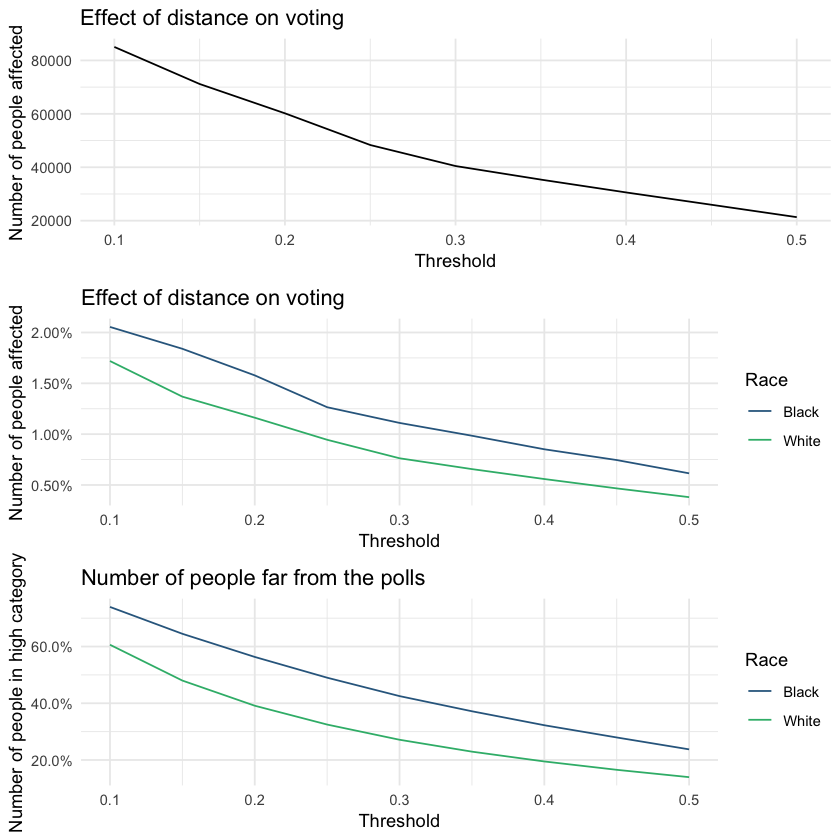

In [19]:
x = seq(from = 0.1, to = .5, by =.05)
y_18_blk = rep(0, length(x))
y_18_wht = rep(0, length(x))
y_18_blk_tot = rep(0, length(x))
y_18_wht_tot = rep(0, length(x))
tot = rep(0, length(x))
T_l<-vector(mode = "list", length=length(x))
T_a<-vector(mode = "list", length=length(x))
y_18_in_l <- vector(mode = "list", length=length(x))
y_18_a_l <- vector(mode = "list", length=length(x))

for(i in 1:length(x)){
    
    y_18_in_l[[i]]<-run_distance(V_roll_hist_census_18_prev, dist_threshold = x[i],  
                           voted_last_flag = FALSE, inc = TRUE
                          )

    y_18_wht[i]<-y_18_in_l[[i]]$white_num
    y_18_blk[i]<-y_18_in_l[[i]]$black_num
    y_18_wht_tot[i]<-y_18_in_l[[i]]$white_tot
    y_18_blk_tot[i]<-y_18_in_l[[i]]$black_tot
    tot[i]<-y_18_in_l[[i]]$tot_num

}
            
white_rolls<-V_roll_hist_census_18_prev[(race == "WH")&vote_type%in%c("in_person", "no_vote"),.N]
black_rolls<-V_roll_hist_census_18_prev[(race == "BH")&vote_type%in%c("in_person", "no_vote"),.N]
    
### get the estimates into a tidy tibble
D_change_18<-tibble(Year=c(rep("2018", length(y_18_blk)*2)), 
       Race=c(rep("White", length(y_18_blk)), rep("Black", length(y_18_blk))) ,
       cutoff = rep(x, 2),
       N=c(y_18_wht,y_18_blk),
       N_tot=c(y_18_wht_tot,y_18_blk_tot),
       total_on_rolls=c(rep(white_rolls, length(y_18_blk)), rep(black_rolls, length(y_18_blk)))
                )

D_tot <- tibble(cutoff = rep(x), tots = tot)

### plotting the estimate against the threshold
p<-D_tot %>% ggplot(aes(x = cutoff, y = tots))+
geom_line()+ theme_minimal()+labs(x = "Threshold", y = "Number of people affected", 
                         title="Effect of distance on voting")

### breaking the plot up by race
p1<-D_change_18 %>% ggplot(aes(x = cutoff, y = N/total_on_rolls, col = Race))+geom_line()+theme_minimal()+
  scale_color_manual(name = "Race",values=viridis(n =4)[2:3])+scale_y_continuous(labels = scales::percent)+
  labs(x = "Threshold", y = "Number of people affected", title="Effect of distance on voting")

### plotting the number of people who are "far" from the polls. This is N_demo
p2<-D_change_18 %>% ggplot(aes(x = cutoff, y = N_tot/total_on_rolls, col = Race))+geom_line()+theme_minimal()+
  scale_color_manual(name = "Race",values=viridis(n =4)[2:3])+scale_y_continuous(labels = scales::percent)+
  labs(x = "Threshold", y = "Number of people in high category", 
       title="Number of people far from the polls")

### arrange the plots
grid.arrange(p, p1, p2)

#### 2018 percent disenfranchised by race

In [23]:
D_change_18 %>% filter(cutoff==.1) %>% mutate(perc = 100*N/total_on_rolls) %>% select(Race, perc)

Race,perc
White,1.719217
Black,2.054708


#### 2018 percent disenfranchised

In [23]:
D_tot[1,2]/V_roll_hist_census_18_prev[vote_type%in%c("in_person", "no_vote"),.N]*100

tots
1.809663


#### 2018 number disenfrachised

In [24]:
D_tot[1,2]

tots
85048.99


#### 2018 percent needed to turn election

In [25]:
((1923685+1978408+D_tot[1,2]$tots)/2-1923685)/D_tot[1,2]$tots*100

[1] 82.17146

### 2018 lowest estimate

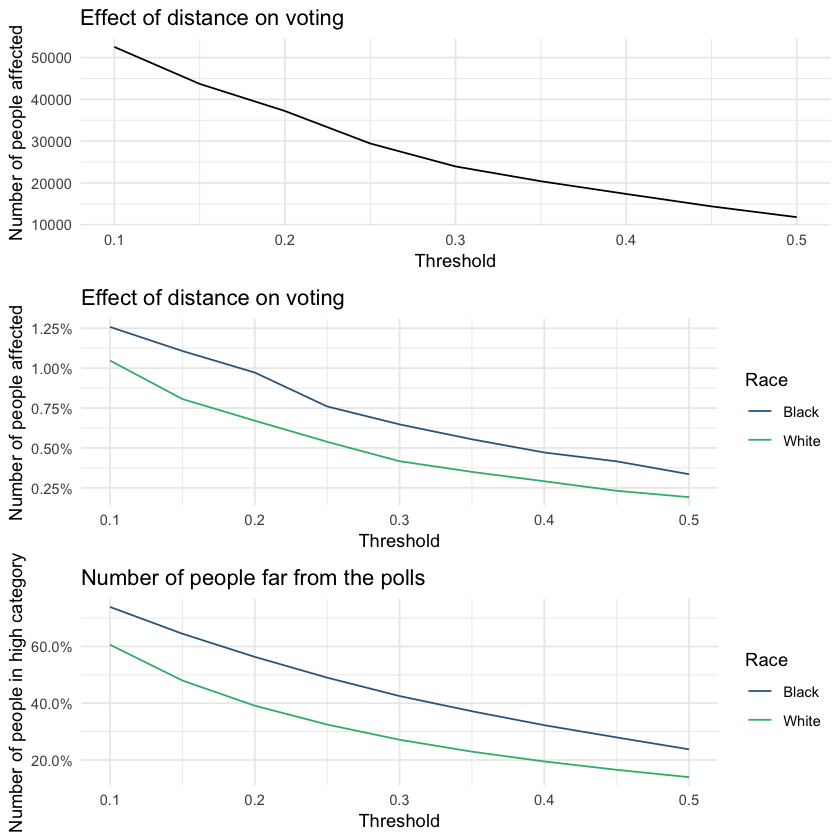

In [13]:
x = seq(from = 0.1, to = .5, by =.05)
y_18_blk = rep(0, length(x))
y_18_wht = rep(0, length(x))
y_18_blk_tot = rep(0, length(x))
y_18_wht_tot = rep(0, length(x))
tot = rep(0, length(x))
T_l<-vector(mode = "list", length=length(x))
T_a<-vector(mode = "list", length=length(x))
y_18_in_l <- vector(mode = "list", length=length(x))
y_18_a_l <- vector(mode = "list", length=length(x))

for(i in 1:length(x)){
    
    y_18_in_l[[i]]<-run_distance(V_roll_hist_census_18_prev, dist_threshold = x[i],  
                           voted_last_flag = TRUE, inc = TRUE
                          )

    y_18_wht[i]<-y_18_in_l[[i]]$white_num
    y_18_blk[i]<-y_18_in_l[[i]]$black_num
    y_18_wht_tot[i]<-y_18_in_l[[i]]$white_tot
    y_18_blk_tot[i]<-y_18_in_l[[i]]$black_tot
    tot[i]<-y_18_in_l[[i]]$tot_num

}
            
white_rolls<-V_roll_hist_census_18_prev[(race == "WH")&vote_type%in%c("in_person", "no_vote"),.N]
black_rolls<-V_roll_hist_census_18_prev[(race == "BH")&vote_type%in%c("in_person", "no_vote"),.N]
    
### get the estimates into a tidy tibble
D_change_18<-tibble(Year=c(rep("2018", length(y_18_blk)*2)), 
       Race=c(rep("White", length(y_18_blk)), rep("Black", length(y_18_blk))) ,
       cutoff = rep(x, 2),
       N=c(y_18_wht,y_18_blk),
       N_tot=c(y_18_wht_tot,y_18_blk_tot),
       total_on_rolls=c(rep(white_rolls, length(y_18_blk)), rep(black_rolls, length(y_18_blk)))
                )

D_tot <- tibble(cutoff = rep(x), tots = tot)

### plotting the estimate against the threshold
p<-D_tot %>% ggplot(aes(x = cutoff, y = tots))+
geom_line()+ theme_minimal()+labs(x = "Threshold", y = "Number of people affected", 
                         title="Effect of distance on voting")

### breaking the plot up by race
p1<-D_change_18 %>% ggplot(aes(x = cutoff, y = N/total_on_rolls, col = Race))+geom_line()+theme_minimal()+
  scale_color_manual(name = "Race",values=viridis(n =4)[2:3])+scale_y_continuous(labels = scales::percent)+
  labs(x = "Threshold", y = "Number of people affected", title="Effect of distance on voting")

### plotting the number of people who are "far" from the polls. This is N_demo
p2<-D_change_18 %>% ggplot(aes(x = cutoff, y = N_tot/total_on_rolls, col = Race))+geom_line()+theme_minimal()+
  scale_color_manual(name = "Race",values=viridis(n =4)[2:3])+scale_y_continuous(labels = scales::percent)+
  labs(x = "Threshold", y = "Number of people in high category", 
       title="Number of people far from the polls")

### arrange the plots
grid.arrange(p, p1, p2)

#### 2018 percent disenfranchised by race

In [14]:
D_change_18 %>% filter(cutoff==.1) %>% mutate(perc = 100*N/total_on_rolls)  %>% select(Race, perc)

Race,perc
White,1.047703
Black,1.258166


In [16]:
D_change_18 %>% filter(cutoff==.1)%>% mutate(perc = 100*N/total_on_rolls)

Year,Race,cutoff,N,N_tot,total_on_rolls,perc
2018,White,0.1,25666.40,1484780,2449777,1.047703
2018,Black,0.1,17337.48,1018768,1377996,1.258166


#### 2018 percent disenfrachised

In [18]:
D_tot[1,2]/V_roll_hist_census_18_prev[vote_type%in%c("in_person", "no_vote"),.N]*100

tots
1.118116


#### 2018 percent needed to turn election

In [74]:
((1923685+1978408+D_tot[1,2]$tots)/2-1923685)/D_tot[1,2]$tots*100

[1] 100.6052

#### 2018 percent disenfranchised

In [77]:
54068/V_roll_hist_census_18_prev[vote_type%in%c("in_person", "no_vote"),.N]*100

[1] 1.150453

### What is the threshold?
Several ideas bear mentioning here, not least an explanation of the threshold's units of measurement. The threshold, which separates those voters who are near their polling places from those who are far from their polling places, is a fraction because, rather than measure the raw distance a voter travels between their home address and the address of their polling place, it measures the proportion of their voting precinct they cross during that trip. Specifically, distance traveled is scaled by the area of the voting precinct it is traveled within. 

This serves a vital purpose because distance is not the same as time, and the latter better represents the obstacles to voting. The burden confronting a suburban voter who travels the 10 miles to their polling place in 10 minutes is less than that which confronts a city voter taking 30 minutes to travel 5 miles, though the raw distance between voter and vote would suggest the opposite. 

### What do the plots say?
Clearly, closer to the polls is better, as the number of voters we would expect to turn out as polls creep closer to homes increases steadily. 

However, by fixing a distance threshold, in reality, what we're doing is fixing a distribution of polling places. The smaller the distance threshold we want, the more polling places we need. To capture as many new voters as possible, polls should be made as close to homes as possible, which means polls should be built as much as possible. 

The situation changes some when we consider the race of the voters we'd expect to vote under a new scattering of polling places. For the larger estimates, the second plot tells us that if polls were built so that all voters were tasked with travelling at most .1 the distance of their precinct to vote, we could expect a 2.1% increase in the black turnout rate. On the other hand, such a change would increase turnout about 1.74% for white voters. The gap (black % - white %) in voter turnout by race increases as we lower the threshold and decreases as we increases it.

Regardless of what distance we consider "far," there are about 10% more black voters than white voters far from their polling places.

## The effect of Shelby v. Holder

Here we present the second major result, that there is a significant change in the distance between voters and polls and, more importantly, a large difference in the effects on turnout between 2012 and 2018, that we attribute to the 2013 Shelby v. Holder decision. We have here a very nice example of a "natural experiment" to test the effectiveness of the Voting Rights Act's preclearance provision. In the year just prior to the Supreme Court's decision, there was an election from we have turnout data. This presents a control of pre-Shelby conditions.

It's true that there is an endless forking path of potential causes of the change and consequences of the case. However, it's also true that there is a direct link between the Shelby decision and the ability to change and close precincts, and likewise, a direct link between the increased distances caused by precinct closures and voter turnout. 

We thus estimate the effect of distance on voter turnout in 2012 and 2018, attributing the difference to the intervention that occured in between--Shelby.

To begin with, we can take a look at the polls that closed and moved after the preclearance coverage formula was struck down. 

In [4]:
pool_of_polls<-polls_locs_12 %>% left_join(polls_locs_18, by = "county")

aa<-pool_of_polls%>% data.table %>% 
  .[,dists:=distHaversine(cbind(as.numeric(long.x),as.numeric(lat.x)), 
                          cbind(as.numeric(long.y),as.numeric(lat.y)))]

dist_of_polls<-aa %>% group_by(PrecinctName, county) %>% summarise(dist_from_poll = min(dists)) %>% na.omit %>% 
  group_by(county) %>% summarise(dist_inc = sum(dist_from_poll)/1609, 
                                 n_diff_a = length(which(dist_from_poll!=0)), n = n()) %>% 
  mutate(perc_diff_a=(n_diff_a)/n)

#### Percent of polls that changed address

In [6]:
(dist_of_polls$n_diff_a %>% sum)/(dist_of_polls$n %>% sum)

[1] 0.3861311

### Shelby lowest estimate

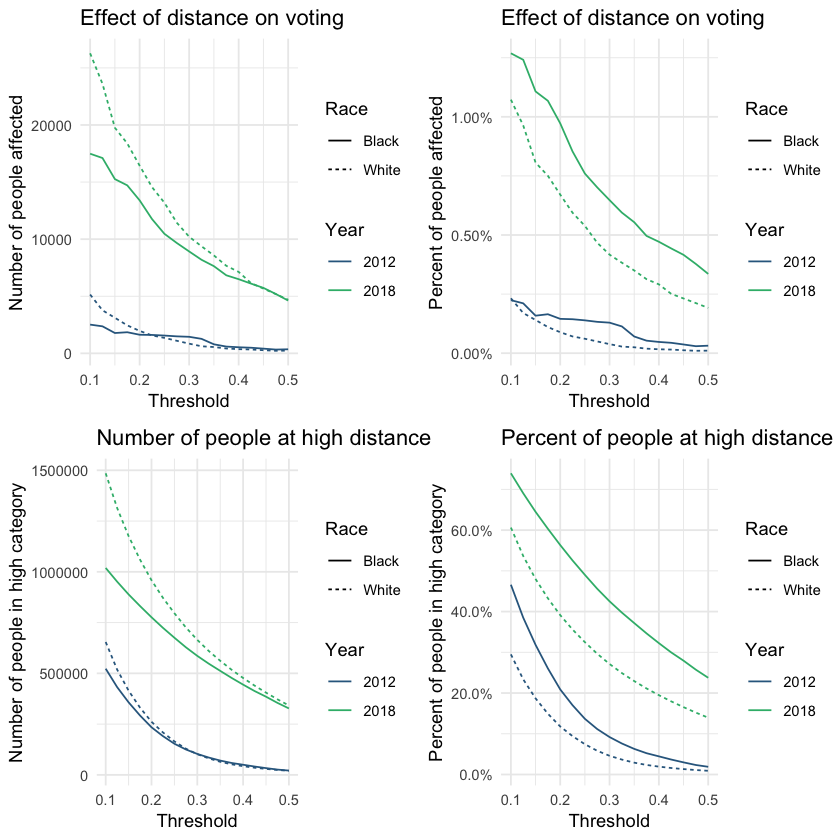

In [103]:
###post shelby changes
x = seq(from = 0.1, to = .5, by =.025)

y_12_blk = rep(0, length(x))
y_12_wht = rep(0, length(x))
y_12_blk_tot = rep(0, length(x))
y_12_wht_tot = rep(0, length(x))
y_12_in_l <- vector(mode = "list", length=length(x))
y_tot_12<-rep(0, length(x))
y_tot_18<-rep(0, length(x))
y_18_blk = rep(0, length(x))
y_18_wht = rep(0, length(x))
y_18_blk_tot = rep(0, length(x))
y_18_wht_tot = rep(0, length(x))
y_18_in_l <- vector(mode = "list", length=length(x))

for(i in 1:length(x)){
    
    y_12_in_l[[i]]<-run_distance(V_roll_hist_census_12, x[i],voted_last_flag = TRUE ,inc = TRUE)
    
    y_12_wht[i]<-y_12_in_l[[i]]$white_num
    y_12_blk[i]<-y_12_in_l[[i]]$black_num
    y_12_wht_tot[i]<-y_12_in_l[[i]]$white_tot
    y_12_blk_tot[i]<-y_12_in_l[[i]]$black_tot
    
    y_18_in_l[[i]]<-run_distance(V_roll_hist_census_18_prev, x[i],voted_last_flag = TRUE ,inc = TRUE)
    
    y_18_wht[i]<-y_18_in_l[[i]]$white_num
    y_18_blk[i]<-y_18_in_l[[i]]$black_num
    y_18_wht_tot[i]<-y_18_in_l[[i]]$white_tot
    y_18_blk_tot[i]<-y_18_in_l[[i]]$black_tot
    
    y_tot_12[i]<-y_12_in_l[[i]]$tot_num
    y_tot_18[i]<-y_18_in_l[[i]]$tot_num
}

D_tot <- tibble(cutoff = rep(x, 2),Year = c(rep("2012", length(x)), rep("2018", length(x))),
                tots = c(y_tot_12, y_tot_18))

white_rolls_18<-V_roll_hist_census_18_prev[(race == "WH")&vote_type%in%c("in_person", "no_vote"),.N]
black_rolls_18<-V_roll_hist_census_18_prev[(race == "BH")&vote_type%in%c("in_person", "no_vote"),.N] 

white_rolls_12<-V_roll_hist_census_12[(race == "WH")&vote_type%in%c("in_person", "no_vote"),.N]
black_rolls_12<-V_roll_hist_census_12[(race == "BH")&vote_type%in%c("in_person", "no_vote"),.N] 

D_change<-tibble(
    Year=c(rep("2018", length(y_18_blk)*2), rep("2012", length(y_12_blk)*2)),
    Race=rep(c(rep("White", length(y_12_blk)), rep("Black", length(y_12_blk))),2),
       cutoff = rep(x, 4),
       N=c(y_18_wht,y_18_blk, y_12_wht,y_12_blk),
       N_tot=c(y_18_wht_tot,y_18_blk_tot, y_12_wht_tot,y_12_blk_tot),
       total_on_rolls=c(rep(white_rolls_18, length(y_18_blk)),
                        rep(black_rolls_18, length(y_18_blk)),
                        rep(white_rolls_12, length(y_12_blk)),
                        rep(black_rolls_12, length(y_12_blk)))
)

p<-D_change %>% ggplot(aes(x = cutoff, y = N, col = Year))+geom_line(aes(linetype = Race))+theme_minimal()+
  scale_color_manual(values=viridis(n =4)[2:4])+
  labs(x = "Threshold", y = "Number of people affected", title="Effect of distance on voting")
  
p1<-D_change %>% ggplot(aes(x = cutoff, y = N/total_on_rolls, col = Year))+geom_line(aes(linetype = Race))+
    theme_minimal()+scale_color_manual(values=viridis(n =4)[2:4])+
    scale_y_continuous(labels = scales::percent)+
    labs(x = "Threshold", y = "Percent of people affected", title="Effect of distance on voting")
  
p2<-D_change %>% ggplot(aes(x = cutoff, y = N_tot, col = Year))+geom_line(aes(linetype = Race))+theme_minimal()+
  scale_color_manual(values=viridis(n =4)[2:4])+
  labs(x = "Threshold", y = "Number of people in high category",title="Number of people at high distance")

p3<-D_change %>% ggplot(aes(x = cutoff, y = N_tot/total_on_rolls, col = Year))+geom_line(aes(linetype = Race))+
    theme_minimal()+scale_color_manual(values=viridis(n =4)[2:4])+ 
    scale_y_continuous(labels = scales::percent)+ 
    labs(x = "Threshold", y = "Percent of people in high category",title="Percent of people at high distance")

p_main<-D_tot %>% ggplot(aes(x=cutoff, y = tots, color = Year))+theme_minimal()+
  scale_color_manual(values=viridis(n =4)[2:4])+geom_line()+ 
    labs(x = "Threshold", y = "Number of people affected",title="People affected 2012 v 2018")

grid.arrange(p,p1,p2,p3, ncol =2, nrow=2)

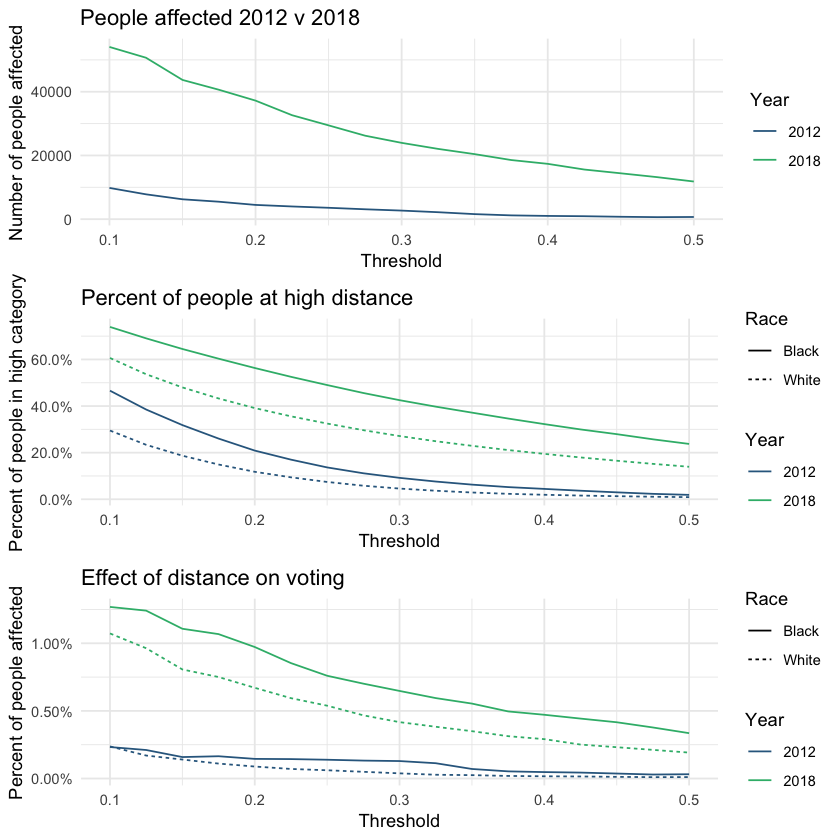

In [80]:
 grid.arrange(p_main, p3,p1)

#### Difference between 2012 and 2018, lowest estimate

In [81]:
D_change %>% filter(cutoff==.1) %>% mutate(perc = N/total_on_rolls, perc_in = N_tot/total_on_rolls)

Year,Race,cutoff,N,N_tot,total_on_rolls,perc,perc_in
2018,White,0.1,26278.824,1485221,2449777,0.010727027,0.6062678
2018,Black,0.1,17484.246,1019083,1377996,0.012688169,0.7395399
2012,White,0.1,5267.375,654407,2218892,0.002373876,0.2949251
2012,Black,0.1,2612.829,522968,1122301,0.002328100,0.4659784


#### Percent disenfranchised in 2012. Compare with same number in the prior section

In [104]:
(D_tot %>% filter(cutoff==.1&Year==2012) %>% pull(tots))/
V_roll_hist_census_18_prev[vote_type%in%c("in_person", "no_vote"),.N]*100

[1] 0.2032429

### Shelby, highest estimate

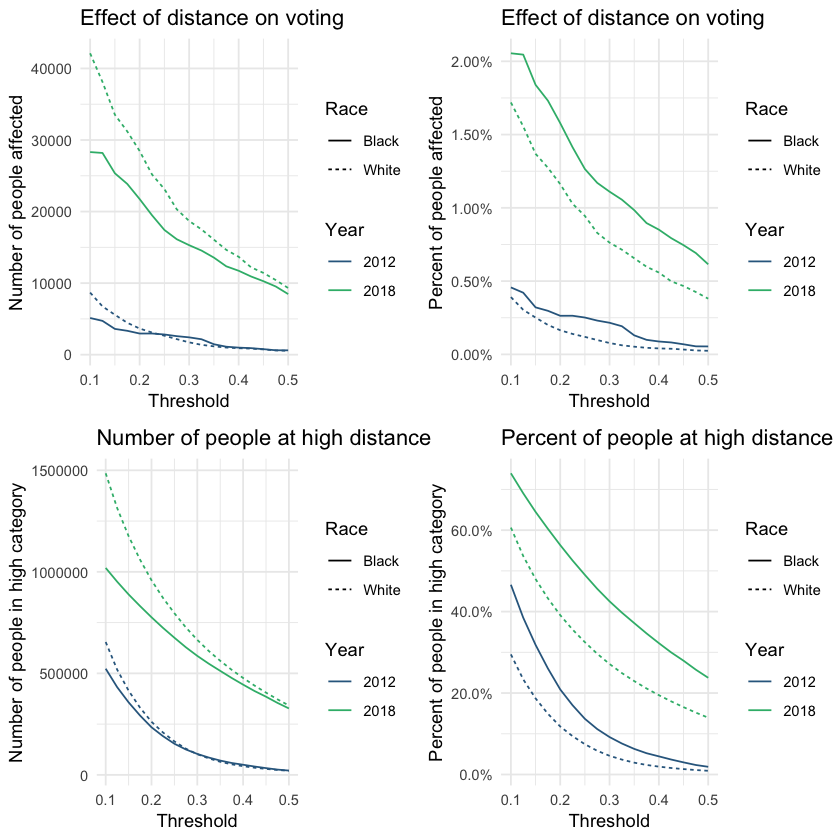

In [27]:
###post shelby changes
x = seq(from = 0.1, to = .5, by =.025)

y_12_blk = rep(0, length(x))
y_12_wht = rep(0, length(x))
y_12_blk_tot = rep(0, length(x))
y_12_wht_tot = rep(0, length(x))
y_12_in_l <- vector(mode = "list", length=length(x))
y_tot_12<-rep(0, length(x))
y_tot_18<-rep(0, length(x))
y_18_blk = rep(0, length(x))
y_18_wht = rep(0, length(x))
y_18_blk_tot = rep(0, length(x))
y_18_wht_tot = rep(0, length(x))
y_18_in_l <- vector(mode = "list", length=length(x))

for(i in 1:length(x)){
    
    y_12_in_l[[i]]<-run_distance(V_roll_hist_census_12, x[i],voted_last_flag = FALSE ,inc = TRUE)
    
    y_12_wht[i]<-y_12_in_l[[i]]$white_num
    y_12_blk[i]<-y_12_in_l[[i]]$black_num
    y_12_wht_tot[i]<-y_12_in_l[[i]]$white_tot
    y_12_blk_tot[i]<-y_12_in_l[[i]]$black_tot
    
    y_18_in_l[[i]]<-run_distance(V_roll_hist_census_18_prev, x[i],voted_last_flag = FALSE ,inc = TRUE)
    
    y_18_wht[i]<-y_18_in_l[[i]]$white_num
    y_18_blk[i]<-y_18_in_l[[i]]$black_num
    y_18_wht_tot[i]<-y_18_in_l[[i]]$white_tot
    y_18_blk_tot[i]<-y_18_in_l[[i]]$black_tot
    
    y_tot_12[i]<-y_12_in_l[[i]]$tot_num
    y_tot_18[i]<-y_18_in_l[[i]]$tot_num
}

D_tot <- tibble(cutoff = rep(x, 2),Year = c(rep("2012", length(x)), rep("2018", length(x))),
                tots = c(y_tot_12, y_tot_18))

white_rolls_18<-V_roll_hist_census_18_prev[(race == "WH")&vote_type%in%c("in_person", "no_vote"),.N]
black_rolls_18<-V_roll_hist_census_18_prev[(race == "BH")&vote_type%in%c("in_person", "no_vote"),.N] 

white_rolls_12<-V_roll_hist_census_12[(race == "WH")&vote_type%in%c("in_person", "no_vote"),.N]
black_rolls_12<-V_roll_hist_census_12[(race == "BH")&vote_type%in%c("in_person", "no_vote"),.N] 

D_change<-tibble(
    Year=c(rep("2018", length(y_18_blk)*2), rep("2012", length(y_12_blk)*2)),
    Race=rep(c(rep("White", length(y_12_blk)), rep("Black", length(y_12_blk))),2),
       cutoff = rep(x, 4),
       N=c(y_18_wht,y_18_blk, y_12_wht,y_12_blk),
       N_tot=c(y_18_wht_tot,y_18_blk_tot, y_12_wht_tot,y_12_blk_tot),
       total_on_rolls=c(rep(white_rolls_18, length(y_18_blk)),
                        rep(black_rolls_18, length(y_18_blk)),
                        rep(white_rolls_12, length(y_12_blk)),
                        rep(black_rolls_12, length(y_12_blk)))
)

p<-D_change %>% ggplot(aes(x = cutoff, y = N, col = Year))+geom_line(aes(linetype = Race))+theme_minimal()+
  scale_color_manual(values=viridis(n =4)[2:4])+
  labs(x = "Threshold", y = "Number of people affected", title="Effect of distance on voting")
  
p1<-D_change %>% ggplot(aes(x = cutoff, y = N/total_on_rolls, col = Year))+geom_line(aes(linetype = Race))+
    theme_minimal()+scale_color_manual(values=viridis(n =4)[2:4])+
    scale_y_continuous(labels = scales::percent)+
    labs(x = "Threshold", y = "Percent of people affected", title="Effect of distance on voting")
  
p2<-D_change %>% ggplot(aes(x = cutoff, y = N_tot, col = Year))+geom_line(aes(linetype = Race))+theme_minimal()+
  scale_color_manual(values=viridis(n =4)[2:4])+
  labs(x = "Threshold", y = "Number of people in high category",title="Number of people at high distance")

p3<-D_change %>% ggplot(aes(x = cutoff, y = N_tot/total_on_rolls, col = Year))+geom_line(aes(linetype = Race))+
    theme_minimal()+scale_color_manual(values=viridis(n =4)[2:4])+ 
    scale_y_continuous(labels = scales::percent)+ 
    labs(x = "Threshold", y = "Percent of people in high category",title="Percent of people at high distance")

p_main<-D_tot %>% ggplot(aes(x=cutoff, y = tots, color = Year))+theme_minimal()+
  scale_color_manual(values=viridis(n =4)[2:4])+geom_line()+ 
    labs(x = "Threshold", y = "Number of people affected",title="People affected 2012 v 2018")

grid.arrange(p,p1,p2,p3, ncol =2, nrow=2)

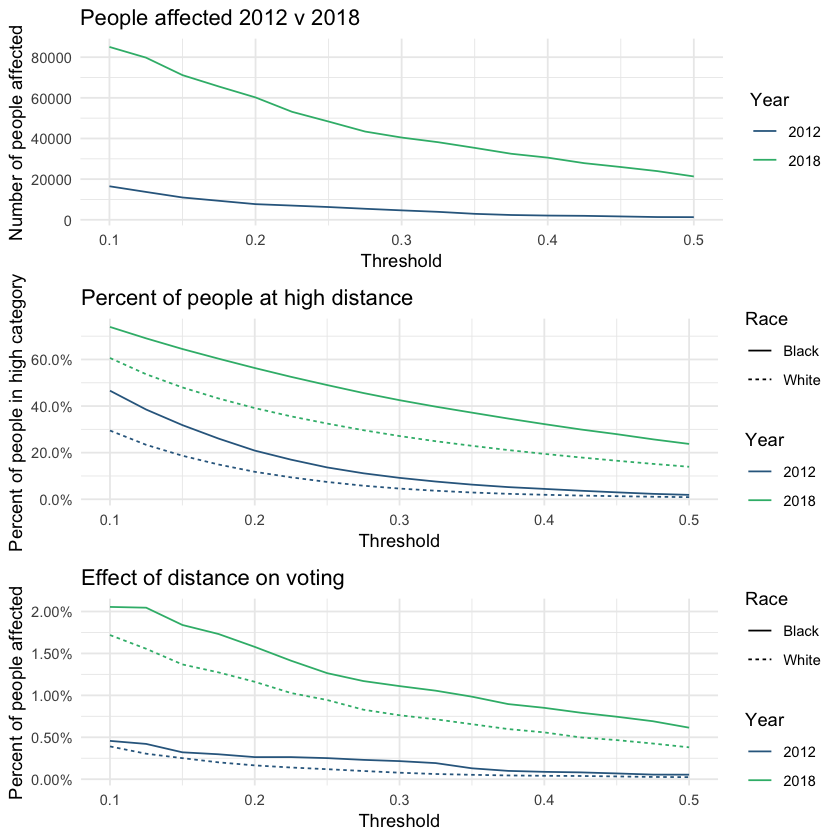

In [89]:
 grid.arrange(p_main, p3,p1)

#### Difference between 2012 and 2018, highest estimate

In [102]:
D_change %>% filter(cutoff==.1) %>% mutate(perc = N/total_on_rolls, perc_in = N_tot/total_on_rolls)

Year,Race,cutoff,N,N_tot,total_on_rolls,perc,perc_in
2018,White,0.1,42116.974,1485329,2449777,0.017192166,0.6063119
2018,Black,0.1,28313.793,1019239,1377996,0.020547079,0.7396531
2012,White,0.1,8676.399,654428,2218892,0.003910239,0.2949346
2012,Black,0.1,5129.098,522969,1122301,0.004570163,0.4659793


#### #### Percent disenfranchised in 2012. Compare with same number in the prior section

In [101]:
(D_tot %>% filter(cutoff==.1&Year==2012) %>% pull(tots))/
V_roll_hist_census_12[vote_type%in%c("in_person", "no_vote"),.N]*100

[1] 0.435744